In [4]:
import numpy as np
from scipy.stats import norm
from scipy import optimize
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from math import *
import pandas as pd
from scipy.optimize import curve_fit,leastsq
import statistics
from scipy import interpolate

<h1>Define<h1>

In [5]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return np.abs(popt)

In [6]:
def gauss_fit_pcov(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return pcov

In [7]:
def MOT_sim(initial_size, temp, order, sigma_raw):
    mu = 0
    sigma_velocity = np.sqrt((k/rubidium_mass)*(temp))
    velocity=np.random.normal(mu,sigma_velocity,10000)
    x_not=np.random.normal(0,(initial_size),10000)
    time = np.arange(0,order+2,1)*1e-3
    data_column = [velocity]+[x_not+(velocity*time[i]) for i in range(order+1)]

    sigma_fit = []
    for j in range(2,order+2):
        mu, std = norm.fit(data_column[j])
        sigma_fit.append(std)

    return np.array(sigma_fit)

In [8]:
def MOT_gen (initial_size,Resolution_data,temp,sigma_raw):
    mu = 0
    sigma_velocity = np.sqrt((k/rubidium_mass)*(temp))
    sigma_fit = []
    velocity=np.random.normal(mu,sigma_velocity,10000)
    x_not=np.random.normal(0,(initial_size),10000)
    point_of_time = sigma_raw.shape[0]
    times = np.arange(0,point_of_time,1)*1e-3
    time = np.linspace(0,point_of_time,Resolution_data)*1e-3
    data_column = [x_not+(velocity*time[i]) for i in range(Resolution_data)]
    for j in range(0,Resolution_data):
        mu, std = norm.fit(data_column[j])
        sigma_fit.append(std)
    return np.array(sigma_fit),times,time

In [9]:
def Multi_MOT_gen(initial_size,Resolution_data,temp,sigma_raw):
    mu = 0
    n = sigma_raw.shape[0]
    x_not = np.random.normal(mu,initial_size,10000)
    times = np.arange(0,n,1)*1e-3
    time = np.linspace(0,n,Resolution_data)*1e-3
    std_fit = []
    for i in range(temp.shape[0]):
        sigma_velocity = np.sqrt((k/rubidium_mass)*(temp[i]))
        std_l = []
        velocity=np.random.normal(mu,sigma_velocity,10000)
        data_column = [x_not+(velocity*time[i]) for i in range(Resolution_data)]
        for j in range(0,Resolution_data):
            mu, std = norm.fit(data_column[j])
            std_l.append(std)
        std_fit.append(std_l)
    return np.array(std_fit),times,time

In [10]:
scale_factor = 2.535111137749588*(10**-5)
sigma_exp_pixel=np.array([22.674836507122023, 22.321439421782348, 24.233914721344025, 27.699338792540498, 30.85363464598624, 41.6176240234315])#, 55.86625225000703, 46.41098514258633, 137.04047126474313, 96.96425476925282])
sigma_err =scale_factor*np.array([0.54697102 ,0.50053797 ,0.64864047 ,0.83312344 ,1.44395329 ,3.30220595 ])#,8.47620527 ,7.22363419 ,165.29643617 ,49.07438558]
sigma_mot_fit = 23.090832364563013
sigma_exp = sigma_exp_pixel*(sigma_mot_fit / sigma_exp_pixel[0]) * scale_factor
rubidium_mass=1.409993e-25
k=1.380649e-23
mu = 0
ini_MOT_size = 0.0005853782630731235

<h1>Cloud atom simulation<h1>

In [2]:
def MOT_sim_his(initial_size, temp, order, sigma_raw):
    mu = 0
    sigma_velocity = np.sqrt((k/rubidium_mass)*(temp))
    velocity=np.random.normal(mu,sigma_velocity,10000)
    x_not=np.random.normal(0,initial_size,10000)
    
    index_column = ['V'] + ['X'+str(k) for k in range(order+1)]
    time = np.arange(0,order+2,1)*1e-3
    data_column = [velocity]+[x_not+(velocity*time[i]) for i in range(order+1)]

    position = pd.DataFrame()
    position = pd.DataFrame({index_column[0]:data_column[0]})
    for j in range(1,order+2):
        position = position.join(pd.DataFrame({index_column[j]:data_column[j]}))

    return position, index_column

In [3]:
color=['red','orange','gold','lightgreen','darkcyan','blue','darkviolet','darkgray']
position_df ,index_column= MOT_sim_his(ini_MOT_size, 300e-6, 7, sigma_exp)
position_df

NameError: name 'ini_MOT_size' is not defined

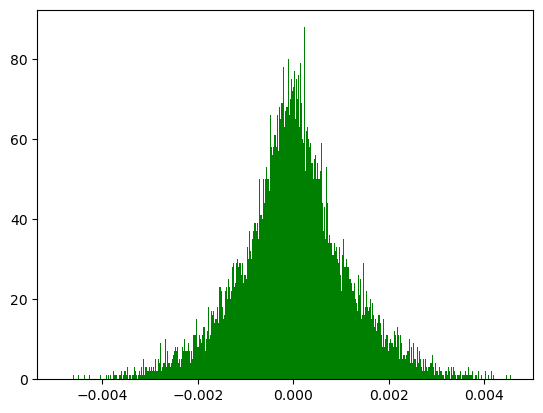

In [10]:
bins_l=[]
n_l=[]

l = len(index_column[1:])
for i in index_column[1:]:
    bins_n=abs(np.max(position_df[i])- np.min(position_df[i]))/0.00001
    n ,bins,p = plt.hist(position_df[i], bins=int(bins_n), facecolor='green', alpha=1)
    n_l.append(n)
    bins_l.append((bins[:-1]+bins[1:])/2)

In [11]:
Cloud_fit =[]
Cloud_std =[]
Cloud_std_err =[]
for i in range(l):
    Cloud_fit.append(gauss(bins_l[i], *gauss_fit(bins_l[i], n_l[i])))
    Cloud_std.append(gauss_fit(bins_l[i], n_l[i])[3])
    pcov_sigma = np.abs(gauss_fit_pcov(bins_l[i], n_l[i]))
    Cloud_std_err.append(np.sqrt(np.diag(pcov_sigma))[3])

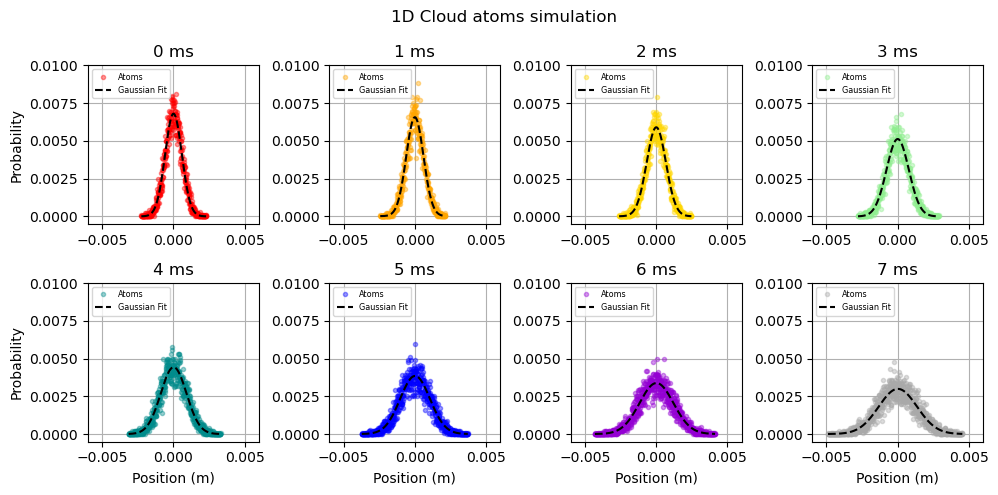

In [457]:
ymax,ymin = 0.01,-0.0005
xmax,xmin = 0.006,-0.006
fig,(axs)=plt.subplots(2,4,figsize=(10,5))
k=0
for g in range(2):
    axs[g,0].set_ylabel('Probability')
    for p in range(4):
        axs[g,p].plot(bins_l[k],n_l[k]/sum(n_l[k]),'.',color = color[k],alpha = 0.4,label = 'Atoms')
        axs[g,p].plot(bins_l[k],Cloud_fit[k]/sum(n_l[k]),'--k',alpha = 1,label = 'Gaussian Fit')
        axs[g,p].set_title(str(k)+' ms')
        axs[g,p].grid()
        axs[g,p].set_xlim(xmin,xmax)
        axs[g,p].set_ylim(ymin,ymax)
        axs[g,p].legend(loc = 'upper left', fontsize = 'xx-small')
        axs[1,p].set_xlabel('Position (m)')
        k+=1
fig.suptitle('1D Cloud atoms simulation')        
fig.tight_layout()

Text(0.5, 0, 'Time (ms)')

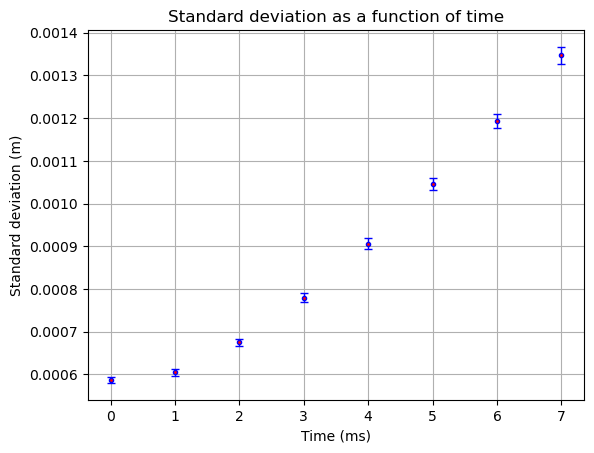

In [452]:
time = np.arange(l)
plt.figure()
plt.title('Standard deviation as a function of time')
plt.grid()
plt.errorbar(time ,Cloud_std, Cloud_std_err,color = 'blue',fmt ='.',label = 'raw data',capsize=3, elinewidth=1, mfc = 'red')
plt.ylabel('Standard deviation (m)')
plt.xlabel('Time (ms)')

<h2>LSW<h2>

In [18]:
def lsq_weight(n,temp_range_min,temp_range_max,sigma_raw_array,sigma_raw_err):
    
    min_lsq = np.inf
    max_lsq = -np.inf
    lsq_list = []
    x_list = []
    y_list = []
    temp_range = np.linspace(temp_range_min,temp_range_max,n)
    n_of_time = len(sigma_raw_array)
    for i in range(n):
        sigma_sim = MOT_sim(ini_MOT_size,temp_range[i],n_of_time,sigma_raw_array)
        y_distance_weight = [((1/(sigma_raw_err[h]**2))*((sigma_raw_array[h]-sigma_sim[h])**2)) for h in range(n_of_time)]
        lsq = np.sum(y_distance_weight)
        std_of_mean = np.sqrt(lsq)/np.sqrt(n_of_time-1)
        
        if(lsq < min_lsq):
            min_lsq = lsq
            real_temp = temp_range[i]
            Percent_err = std_of_mean
        if(lsq > max_lsq):
            max_lsq = lsq
        lsq_list.append(lsq)
    coef = np.polyfit(temp_range,lsq_list,4)
    poly1d = np.poly1d(coef)
    min_n = np.where(poly1d(temp_range) == np.min(poly1d(temp_range)))
    temp_mean = temp_range[min_n][0]
    
    min_x = np.where(poly1d(temp_range) <= poly1d(temp_mean) + Percent_err**2)
    temp_min, temp_max = temp_range[np.min(min_x)], temp_range[np.max(min_x)]
    return lsq_list , temp_range, poly1d(temp_range), temp_min, temp_max, temp_mean, min_x, poly1d(temp_mean)+Percent_err**2

In [19]:
lsq_data_weight, temp_ranges_weight, lsq_fit_weight, MOT_temp_min, MOT_temp_max, MOT_temp_mean, temp_range_linear, err= lsq_weight(200,0e-6,210e-6,sigma_exp,sigma_err)

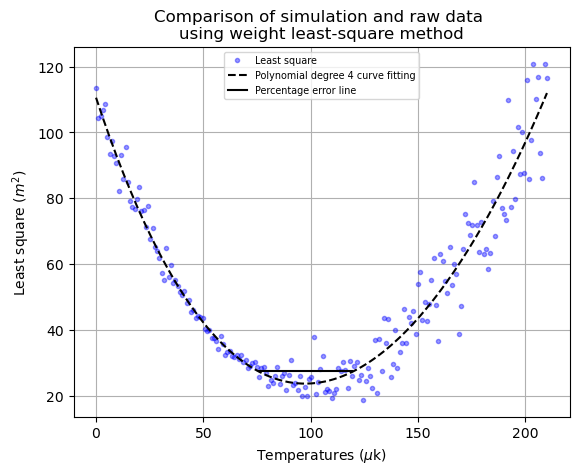

In [20]:
plt.figure()
plt.plot(temp_ranges_weight*1000000,lsq_data_weight,'.',label = 'Least square',alpha = 0.4, color ='blue')
plt.plot(temp_ranges_weight*1000000,lsq_fit_weight,'--',color = 'black',label = 'Polynomial degree 4 curve fitting')
plt.plot(temp_ranges_weight[temp_range_linear[0]]*1000000,err*np.ones(np.shape(temp_range_linear)[1]),color = 'black',label = 'Percentage error line')
plt.legend(loc = 'upper center',fontsize= 'x-small')
y_label = plt.ylabel(r'Least square ($m^2$)')
x_label = plt.xlabel('Temperatures ($\mu$k)')
plt.grid()
plt.title('Comparison of simulation and raw data \nusing weight least-square method')
plt.savefig('Comparison of simulation and raw data using weight least-square method')

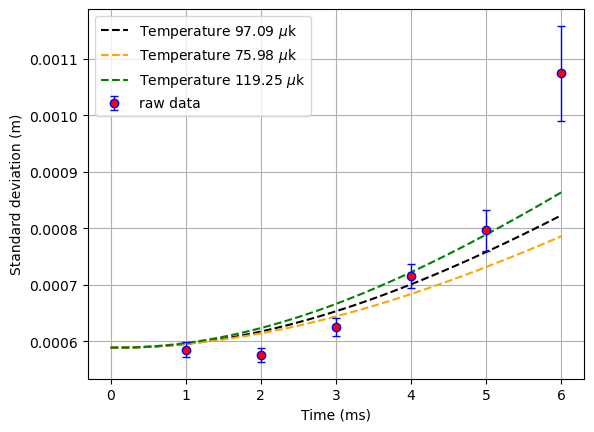

In [21]:
Temp_array = np.array([MOT_temp_min, MOT_temp_mean, MOT_temp_max],dtype = float)
Cloud_gen, times, time = Multi_MOT_gen(ini_MOT_size,200,Temp_array,sigma_exp)
plt.figure()
plt.plot(time*1000,Cloud_gen[1],'--k',label = 'Temperature '+str(np.round(Temp_array[1]*1000000,2))+' $\mu$k')
plt.plot(time*1000,Cloud_gen[0],'--',color= 'orange',label = 'Temperature '+str(np.round(Temp_array[0]*1000000,2))+' $\mu$k')
plt.plot(time*1000,Cloud_gen[2],'--',color= 'green',label = 'Temperature '+str(np.round(Temp_array[2]*1000000,2))+' $\mu$k')
plt.errorbar(np.arange(1,7) ,sigma_exp, sigma_err,color = 'blue',fmt ='o',label = 'raw data',capsize=3, elinewidth=1, mfc = 'red')
y_label = plt.ylabel('Standard deviation (m)')
x_label = plt.xlabel('Time (ms)')
plt.grid()
plt.legend()

<h2>LS + errorbar<h2>

In [207]:
def lsq_normal(n,temp_range_min,temp_range_max,sigma_raw_array):
    
    min_lsq = np.inf
    max_lsq = -np.inf
    lsq_list = []
    x_list = []
    y_list = []
    temp_range = np.linspace(temp_range_min,temp_range_max,n)
    n_of_time = len(sigma_exp)
    
    for i in range(n):
        sigma_sim = MOT_sim(ini_MOT_size,temp_range[i],n_of_time,sigma_exp)
        y_distance = (sigma_exp-sigma_sim)
        lsq = np.sum(y_distance**2)
        
        if(lsq < min_lsq):
            min_lsq = lsq
            real_temp = temp_range[i]

        if(lsq > max_lsq):
            max_lsq = lsq
        lsq_list.append(lsq)
    coef = np.polyfit(temp_range,lsq_list,4)
    poly1d = np.poly1d(coef)
    min_n = np.where(poly1d(temp_range) == np.min(poly1d(temp_range)))
    temp_minimum = temp_range[min_n][0]
    
    return lsq_list,temp_minimum, temp_range, poly1d(temp_range)

In [208]:
lsq_data, nMOT_temp, temp_ranges, nlsq_fit = lsq_normal(200,0e-6,390e-6,sigma_exp)
sigma_max, sigma_min = sigma_exp + sigma_err, sigma_exp - sigma_err
lsq_max, nMOT_temp_max, temp_ranges_max, lsq_fit_max = lsq_normal(200,0e-6,390e-6,sigma_max)
lsq_min, nMOT_temp_min, temp_ranges_min, lsq_fit_min = lsq_normal(200,0e-6,390e-6,sigma_min)

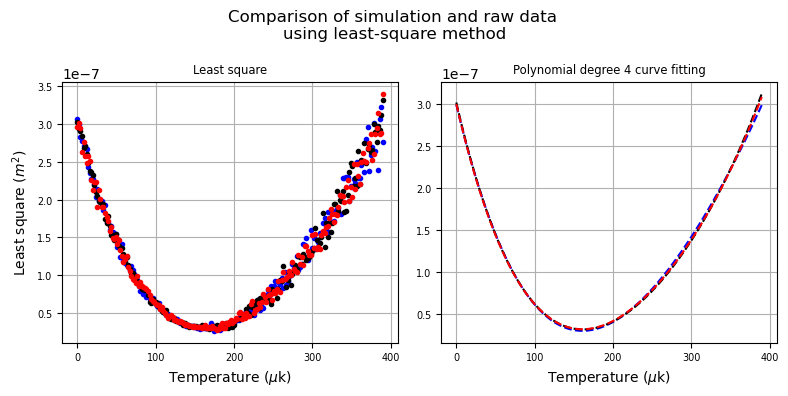

In [209]:
colormap_fig2 = 'afmhot'
fig = plt.figure(figsize=(8, 4))
axs = np.zeros(2, dtype=object)
gs = fig.add_gridspec(1, 2)
axs[0] = fig.add_subplot(gs[0, 0])
axs[1] = fig.add_subplot(gs[0, 1])

axs1 = axs[0].plot(temp_ranges*1000000,lsq_min,'.b')
axs1 = axs[0].plot(temp_ranges*1000000,lsq_data,'.k')
axs1 = axs[0].plot(temp_ranges*1000000,lsq_max,'.r')
axs[0].set_title('Least square',fontsize ='small')
axs[0].set_xlabel('Temperature ($\mu$k)')
axs[0].set_ylabel(r'Least square ($m^2$)')
axs[0].grid()
axs2 = axs[1].plot(temp_ranges*1000000,lsq_fit_min,'--b')
axs2 = axs[1].plot(temp_ranges*1000000,nlsq_fit,'--k')
axs2 = axs[1].plot(temp_ranges*1000000,lsq_fit_max,'--r')
axs[1].set_title('Polynomial degree 4 curve fitting',fontsize ='small')
axs[1].set_xlabel('Temperature ($\mu$k)')
axs[1].grid()

for x in axs.flat:
    for tick in x.xaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
    for tick in x.yaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
fig.suptitle('Comparison of simulation and raw data \nusing least-square method')
fig.tight_layout()
plt.savefig('Full subtract signal method at 1ms.png')

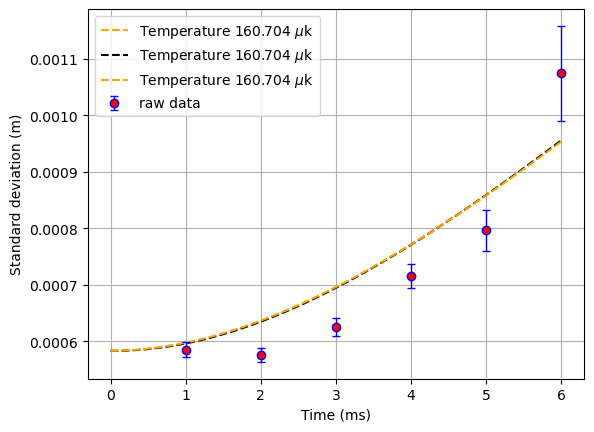

In [244]:
nTemp_array = np.array([nMOT_temp_min, nMOT_temp, nMOT_temp_max],dtype = float)
nCloud_gen, times, time = Multi_MOT_gen(ini_MOT_size,200,nTemp_array,sigma_exp)
plt.figure()
plt.plot(time*1000,nCloud_gen[0],'--',color= 'orange',label = 'Temperature '+str(np.round(nTemp_array[0]*1000000,3))+' $\mu$k')
plt.plot(time*1000,nCloud_gen[1],'--k',label = 'Temperature '+str(np.round(nTemp_array[1]*1000000,3))+' $\mu$k')
plt.plot(time*1000,nCloud_gen[2],'--',color= 'orange',label = 'Temperature '+str(np.round(nTemp_array[2]*1000000,3))+' $\mu$k')
plt.errorbar(np.arange(1,7) ,sigma_exp, sigma_err,color = 'blue',fmt ='o',label = 'raw data',capsize=3, elinewidth=1, mfc = 'red')
y_label = plt.ylabel('Standard deviation (m)')
x_label = plt.xlabel('Time (ms)')
plt.grid()
plt.legend()

<h1>2D fitting<h1>

In [11]:
def lsq_2params(n,temp_range_min,temp_range_max,m,size_min,size_max,sigma_raw_array,sigma_raw_err):
    
    min_lsq = np.inf
    max_lsq = -np.inf
    n_of_time = len(sigma_raw_array)
    temp_range = np.linspace(temp_range_min,temp_range_max,n)
    size_range = np.linspace(size_min,size_max,m)
    twoD_lsq = []
    twoD_lsq_fit = []
    for j in range(m):
        x_list = []
        y_list = []    
        lsq_list = []
        for i in range(n):
            sigma_sim = MOT_sim(size_range[j],temp_range[i],n_of_time,sigma_raw_array)
            y_distance_weight = [((1/(sigma_raw_err[h]**2))*((sigma_raw_array[h]-sigma_sim[h])**2)) for h in range(n_of_time)]
            lsq = np.sum(y_distance_weight)
            std_of_mean = np.sqrt(lsq)/np.sqrt(n_of_time-1)
            if(lsq < min_lsq):
                min_lsq = lsq
                coordinate = np.array([j,i])
                real_temp = temp_range[i]
                real_size = size_range[j]
                Percent_err = std_of_mean**2
                # print(j,i,real_temp,real_size,coordinate)
            if(lsq > max_lsq):
                max_lsq = lsq
            lsq_list.append(lsq)   
        twoD_lsq.append(lsq_list)
        
        coef = np.polyfit(temp_range,lsq_list,4)
        poly1d = np.poly1d(coef)
        twoD_lsq_fit.append(poly1d(temp_range))
    return np.array(twoD_lsq_fit), temp_range, size_range, real_temp , real_size , np.array(twoD_lsq[coordinate[0]]), np.array(twoD_lsq[coordinate[1]]), Percent_err

In [12]:
temp_min_fit,temp_max_fit,size_min_fit,size_max_fit = 0,400,0.4,0.7 
lsq_data,temp_range_lsq,size_range_lsq,MOT_temp_2params,MOT_size,lsq_temp,lsq_size,err = lsq_2params(51,temp_min_fit*1e-6,temp_max_fit*1e-6,51,size_min_fit*1e-3,size_max_fit*1e-3,sigma_exp,sigma_err)

In [13]:
t_range_lsq = np.linspace(np.min(temp_range_lsq),np.max(temp_range_lsq),201)
tcoef = np.polyfit(temp_range_lsq,lsq_temp,4)
tpoly1d = np.poly1d(tcoef)
lsq_t = tpoly1d(t_range_lsq)

s_range_lsq = np.linspace(np.min(size_range_lsq),np.max(size_range_lsq),201)
scoef = np.polyfit(size_range_lsq,lsq_size,4)
spoly1d = np.poly1d(scoef)
lsq_s = spoly1d(s_range_lsq)

min_temp_range = np.where(lsq_t <= round(np.min(lsq_t) + err))
temp_min, temp_max = t_range_lsq[np.min(min_temp_range)], t_range_lsq[np.max(min_temp_range)]
temp_mean = t_range_lsq[int(np.mean(min_temp_range))]

min_size_range = np.where(lsq_s <= round(np.min(lsq_s) + err))
size_min, size_max = s_range_lsq[np.min(min_size_range)], s_range_lsq[np.max(min_size_range)]
size_mean = s_range_lsq[int(np.mean(min_size_range))]

point_lsq_t = np.array([lsq_t[np.min(min_temp_range)]+1,lsq_t[int(np.mean(min_temp_range))],lsq_t[np.max(min_temp_range)]+1],dtype = int)
point_lsq_t_range = np.array([t_range_lsq[np.min(min_temp_range)],t_range_lsq[int(np.mean(min_temp_range))],t_range_lsq[np.max(min_temp_range)]])

point_lsq_s = np.array([lsq_s[np.min(min_size_range)]+1,lsq_s[int(np.mean(min_size_range))],lsq_s[np.max(min_size_range)]+1],dtype = int)
point_lsq_s_range = np.array([s_range_lsq[np.min(min_size_range)],s_range_lsq[int(np.mean(min_size_range))],s_range_lsq[np.max(min_size_range)]])

Text(0.5, 1.0, '2D Least-square method')

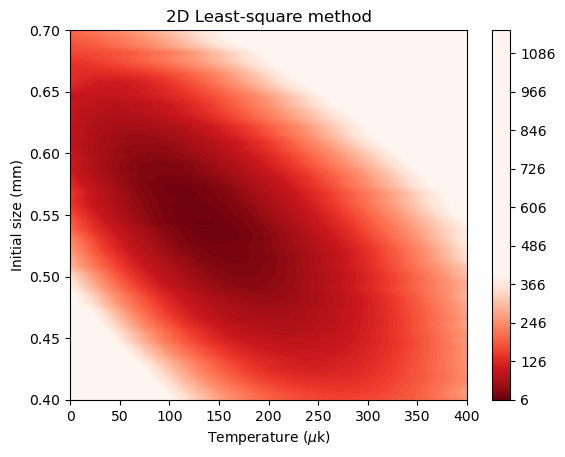

In [14]:
plt.contourf(lsq_data,200,cmap = 'Reds_r',extent = (temp_min_fit,temp_max_fit,size_min_fit,size_max_fit) ,vmax =400)
# plt.plot(MOT_temp_2params*1000000,MOT_size*1000,'.',color = 'cyan',label = str(np.round(MOT_size*1000,3))+' mm and '+str(np.round(MOT_temp_2params*1000000,2))+' $\mu$k ')
plt.colorbar()
plt.xlabel('Temperature ($\mu$k)')
plt.ylabel('Initial size (mm)')
plt.title('2D Least-square method')
# plt.legend()

In [15]:
# MOT_2params_sim, times, time = MOT_gen (MOT_size,200,MOT_temp_2params,sigma_exp)
# plt.figure()
# plt.errorbar(times+0.001 ,sigma_exp*1000, sigma_err*1000,color = 'blue',fmt ='o',label = 'raw data',capsize=3, elinewidth=1, mfc = 'red')
# plt.plot(time,MOT_2params_sim*1000,'--k',label = 'Temperature '+str(np.round(MOT_temp_2params*1000000,3))+' $\mu$k and '+str(np.round(MOT_size*1000,3))+' m')
# plt.legend(loc = 'upper left',fontsize ='small')
# y_label = plt.ylabel('Standard deviation(mm)')
# x_label = plt.xlabel('Time(seconds)')


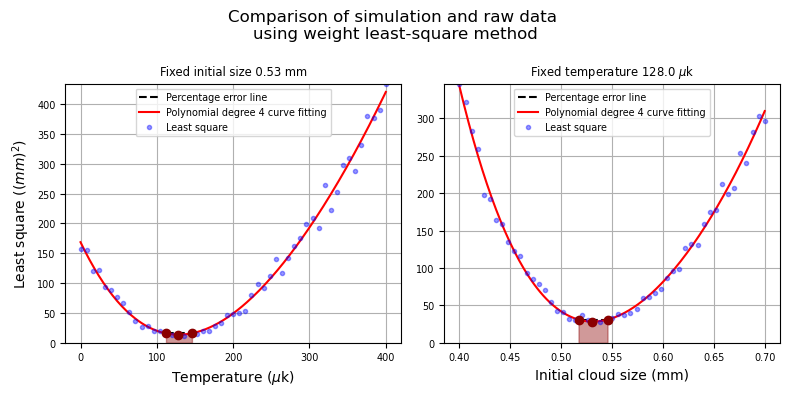

In [21]:
colormap_fig2 = 'afmhot'
fig = plt.figure(figsize=(8, 4))
axs = np.zeros(2, dtype=object)
gs = fig.add_gridspec(1, 2)
axs[0] = fig.add_subplot(gs[0, 0])
axs[1] = fig.add_subplot(gs[0, 1])

axs1 = axs[0].plot(t_range_lsq[min_temp_range[0]]*1000000,round(np.min(lsq_t) + err)*np.ones(np.shape(min_temp_range)[1]),'--k',label = 'Percentage error line')
axs1 = axs[0].plot(t_range_lsq*1000000,lsq_t,'-r', label = 'Polynomial degree 4 curve fitting')
axs1 = axs[0].plot(temp_range_lsq*1000000,lsq_temp,'.b',alpha = 0.4, label = 'Least square')
axs1 = axs[0].plot(point_lsq_t_range*1000000,point_lsq_t,'o',color = 'darkred')
axs1 = axs[0].fill_between(point_lsq_t_range*1000000, 0, point_lsq_t,alpha = 0.4,color = 'darkred')
axs[0].set_title('Fixed initial size ' + str(round(size_mean*1000,3))+' mm',fontsize ='small')
axs[0].set_xlabel('Temperature ($\mu$k)')
axs[0].set_ylabel(r'Least square ($(mm)^2$)')
axs[0].set_ylim(0,np.max(lsq_temp))
axs[0].legend(loc = 'upper center', fontsize = 'x-small')
axs[0].grid()

axs2 = axs[1].plot(s_range_lsq[min_size_range[0]]*1000,round(np.min(lsq_s) + err)*np.ones(np.shape(min_size_range)[1]),'--k', label = 'Percentage error line')
axs2 = axs[1].plot(s_range_lsq*1000,lsq_s,'-r', label = 'Polynomial degree 4 curve fitting')
axs2 = axs[1].plot(size_range_lsq*1000,lsq_size,'.b',alpha = 0.4, label = 'Least square')
axs2 = axs[1].plot(point_lsq_s_range*1000,point_lsq_s,'o',color = 'darkred')
axs2 = axs[1].fill_between(point_lsq_s_range*1000, 0, point_lsq_s,alpha = 0.4,color = 'darkred')
axs[1].set_title('Fixed temperature ' + str(round(temp_mean*1000000,3)) +' $\mu$k',fontsize ='small')
axs[1].set_xlabel('Initial cloud size (mm)')

axs[1].set_ylim(0,np.max(lsq_size))
axs[1].legend(loc = 'upper center', fontsize = 'x-small')
axs[1].grid()

for x in axs.flat:
    for tick in x.xaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
    for tick in x.yaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
fig.suptitle('Comparison of simulation and raw data \nusing weight least-square method')
fig.tight_layout()

In [30]:
Temp_array = np.array([temp_min, temp_mean, temp_max],dtype = float)
Cloud_gen_fs_min, times, time = Multi_MOT_gen(size_min,200,Temp_array,sigma_exp)
Cloud_gen_fs_mean, times, time = Multi_MOT_gen(size_mean,200,Temp_array,sigma_exp)
Cloud_gen_fs_max, times, time = Multi_MOT_gen(size_max,200,Temp_array,sigma_exp)

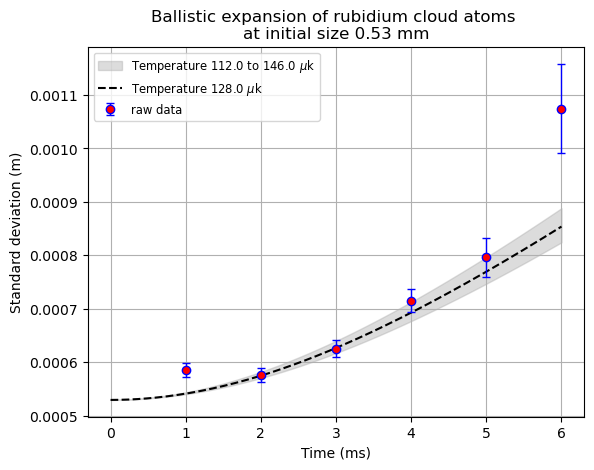

In [31]:
plt.figure()

# plt.plot(time*1000,Cloud_gen_fs_min[0],'--',color= 'gold',label = 'Temperature '+str(np.round(Temp_array[0]*1000000,2))+' $\mu$k at initial size ' + str(round(size_min*1000,3))+' mm')
# plt.plot(time*1000,Cloud_gen_fs_min[1],'--',color= 'gray',label = 'Temperature '+str(np.round(Temp_array[1]*1000000,2))+' $\mu$k at initial size ' + str(round(size_min*1000,3))+' mm')
# plt.plot(time*1000,Cloud_gen_fs_min[2],'--',color= 'lime',label = 'Temperature '+str(np.round(Temp_array[2]*1000000,2))+' $\mu$k at initial size ' + str(round(size_min*1000,3))+' mm')
plt.fill_between(time*1000, Cloud_gen_fs_mean[0], Cloud_gen_fs_mean[2],alpha = 0.4,color = 'darkgray',label = 'Temperature '+str(np.round(Temp_array[0]*1000000,3))+' to '+str(np.round(Temp_array[2]*1000000,3))+' $\mu$k')
plt.plot(time*1000,Cloud_gen_fs_mean[1],'--',color= 'black',label = 'Temperature '+str(np.round(Temp_array[1]*1000000,3))+' $\mu$k')# at initial sizstr(np.round(Temp_array[1]*1000000,3))e ' + str(round(size_mean*1000,3))+' mm')

# plt.plot(time*1000,Cloud_gen_fs_max[0],'--',color= 'darkorange',label = 'Temperature '+str(np.round(Temp_array[0]*1000000,2))+' $\mu$k at initial size ' + str(round(size_max*1000,3))+' mm')
# plt.plot(time*1000,Cloud_gen_fs_max[1],'--',color= 'black',label = 'Temperature '+str(np.round(Temp_array[1]*1000000,2))+' $\mu$k at initial size ' + str(round(size_max*1000,3))+' mm')
# plt.plot(time*1000,Cloud_gen_fs_max[2],'--',color= 'darkgreen',label = 'Temperature '+str(np.round(Temp_array[2]*1000000,2))+' $\mu$k at initial size ' + str(round(size_max*1000,3))+' mm')

plt.errorbar(np.arange(1,7) ,sigma_exp, sigma_err,color = 'blue',fmt ='o',label = 'raw data',capsize=3, elinewidth=1, mfc = 'red')
y_label = plt.ylabel('Standard deviation (m)')
x_label = plt.xlabel('Time (ms)')
plt.title('Ballistic expansion of rubidium cloud atoms \nat initial size ' + str(round(size_mean*1000,3))+' mm')
plt.legend(loc = 'upper left', fontsize = 'small')
plt.grid()
